In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Import libraries

In [26]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow.keras.layers as tfl
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

# Visualizing data

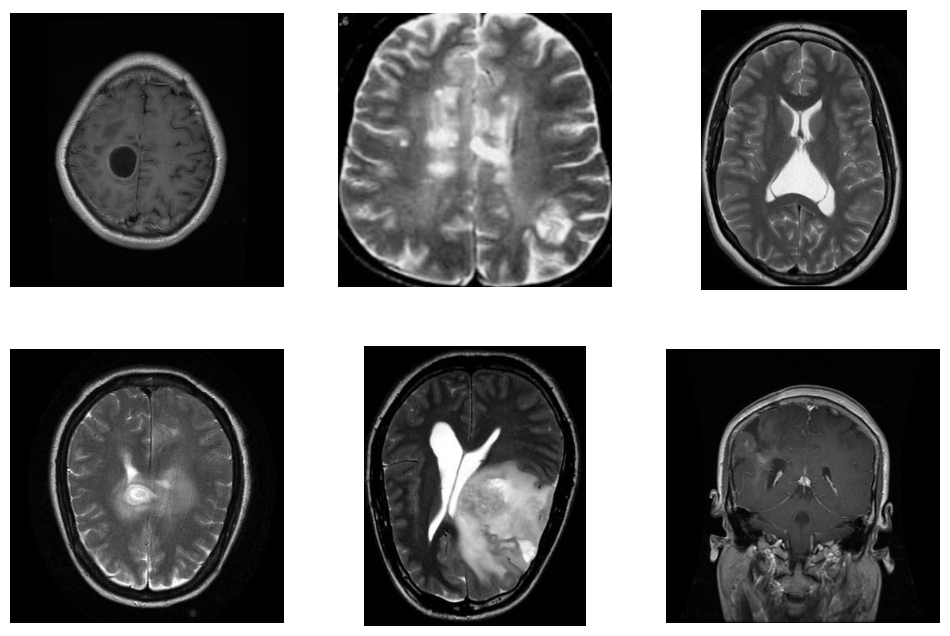

In [27]:
# Brain Tumor Images
folder_path = '/kaggle/input/brian-tumor-dataset/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor'
image_files_tumor = [file for file in os.listdir(folder_path)]

num_images = min(6, len(image_files_tumor))
num_rows = (num_images - 1) // 3 + 1

fig, axes = plt.subplots(num_rows, 3, figsize=(12, 4 * num_rows))

for i in range(num_images):
    image_path = os.path.join(folder_path, image_files_tumor[i])
    img = mpimg.imread(image_path)
    # print(img.shape)
    ax = axes[i // 3, i % 3]
    ax.imshow(img)
    ax.axis('off')

plt.show()

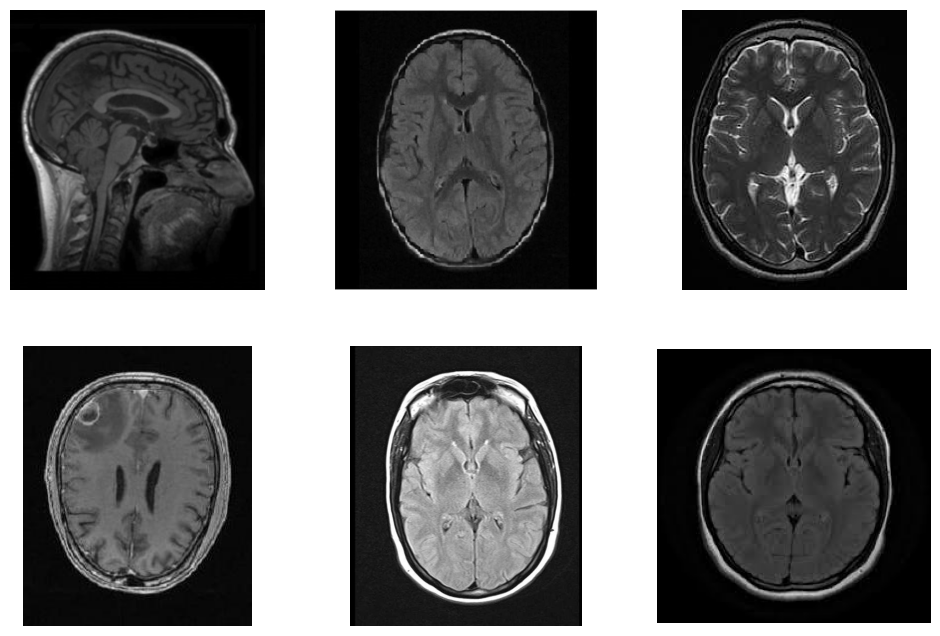

In [28]:
# Healthy Images
folder_path = '/kaggle/input/brian-tumor-dataset/Brain Tumor Data Set/Brain Tumor Data Set/Healthy'
image_files_healthy = [file for file in os.listdir(folder_path)]
num_images = min(6, len(image_files_healthy))
num_rows = (num_images - 1) // 3 + 1

fig, axes = plt.subplots(num_rows, 3, figsize=(12, 4 * num_rows))

for i in range(num_images):
    image_path = os.path.join(folder_path, image_files_healthy[i])
    img = mpimg.imread(image_path)
    ax = axes[i // 3, i % 3]
    ax.imshow(img)
    ax.axis('off')

plt.show()

In [29]:
print("Number of Tumor Images in the directory:",len(image_files_tumor))
print("Number of Healthy Images in the directory:",len(image_files_healthy))

Number of Tumor Images in the directory: 2513
Number of Healthy Images in the directory: 2087


# ImageDataGenerator

In [30]:
# Define the image size and batch size
img_height, img_width = 224, 224
batch_size = 512

# Create an ImageDataGenerator object
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,  # normalize pixel values
    validation_split=0.2,  # reserve some images for validation
)

# Load the training dataset

train_dataset = datagen.flow_from_directory(
    '/kaggle/input/brian-tumor-dataset/Brain Tumor Data Set/Brain Tumor Data Set/',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    color_mode='grayscale',
    interpolation='bilinear', # strategy used for resampling when resizing
    subset='training',
)

# Load the validation dataset
validation_dataset = datagen.flow_from_directory(
    '/kaggle/input/brian-tumor-dataset/Brain Tumor Data Set/Brain Tumor Data Set/',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    color_mode='grayscale',
    interpolation='bilinear', # strategy used for resampling when resizing
    subset='validation',
)

Found 3681 images belonging to 2 classes.
Found 919 images belonging to 2 classes.


# Graph Plotting Function

In [31]:
# plot metrics
def plot_metrics(history):
    metrics = ["loss", "accuracy", "prc", "Precision", "Recall"]
    plt.figure(figsize=(16, 10))
    
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        
        plt.subplot(3,2,n+1)
        plt.plot(history.epoch, history.history[metric], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        plt.grid(True)
        
        # Adjust y-axis limits for better visualization
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        else:
            plt.ylim([0,1])

        plt.legend()
    

# CNN Model

In [32]:
def build_model(metrics, epoch = 20):
    # Clear any previous model session to start fresh
    tf.keras.backend.clear_session()

    # Initialize a Sequential model
    model = tf.keras.models.Sequential()

    # Add a 2D convolution layer with 16 filters, a 3x3 kernel, and 'relu' activation function
    model.add(tfl.Conv2D(16, (3, 3), activation='relu', padding = "same", input_shape=(img_height, img_width, 1)))

    # Add a max pooling layer to reduce the spatial dimensions of the output volume
    model.add(tfl.MaxPooling2D((2, 2)))

    # Add another convolution and max pooling layer
    model.add(tfl.Conv2D(8, (3, 3), activation='relu', padding = "same"))
    model.add(tfl.MaxPool2D((2,2)))
    
    # Flatten the tensor output from the previous layer to create a single long feature vector
    model.add(tfl.Flatten())
    
    # Add a dense layer with 8 neurons and 'relu' activation function
    model.add(tfl.Dense(8, activation='relu'))

    # Add batch normalization layer to normalize the activations of the previous layer
    model.add(tfl.BatchNormalization())

    # Add a dropout layer to prevent overfitting
    model.add(tfl.Dropout(0.3))

    # Add the output layer with a single neuron (for binary classification) and 'sigmoid' activation function
    model.add(tfl.Dense(1, activation='sigmoid'))

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=metrics)
    
    model.summary()

    history = model.fit(train_dataset, validation_data=validation_dataset, epochs=epoch, verbose=1)

    plot_metrics(history)

    # Return the trained model and its history
    return model, history

In [33]:
# Define the metrics for the model to judge on
metrics = [ tf.keras.metrics.BinaryAccuracy(name="accuracy"),
            tf.keras.metrics.F1Score(name='F1'),
            tf.keras.metrics.Recall(name='Recall'),
            tf.keras.metrics.Precision(name='Precision'),
            tf.keras.metrics.AUC(name='prc', curve='PR')]

# Training

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 8)       1160      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 8)         0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 8)                 2

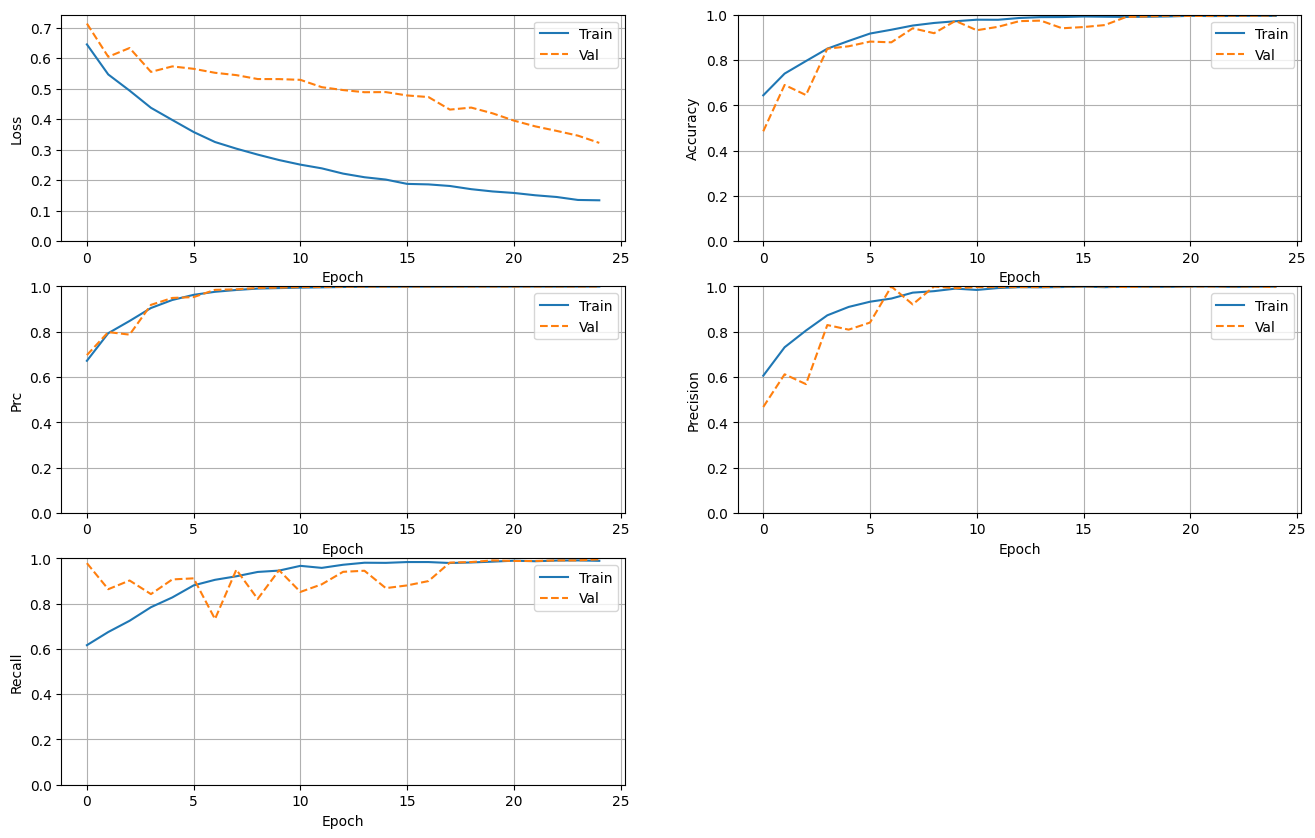

In [34]:
model, history = build_model(metrics, epoch = 25)

In [35]:
model.evaluate(validation_dataset)

2/2 [==============================] - 4s 2s/step - loss: 0.3222 - accuracy: 0.9967 - F1: 0.6243 - Recall: 0.9952 - Precision: 0.9976 - prc: 0.9999


[0.3222099244594574,
 0.9967355728149414,
 array([0.6242515], dtype=float32),
 0.9952038526535034,
 0.9975961446762085,
 0.9999068975448608]

In [36]:
# getting labels of the validation_dataset for plotting confusion matrix
steps = validation_dataset.samples // validation_dataset.batch_size
if validation_dataset.samples % validation_dataset.batch_size > 0:
    steps += 1

images_list = []
y_true = []

for i, (images, labels) in enumerate(validation_dataset):
    if i >= steps:
        break
    images_list.extend(images)
    y_true.extend(labels)

images_array = np.array(images_list)
y_true = np.array(y_true)

# Confusion Matrix

29/29 [==============================] - 0s 6ms/step


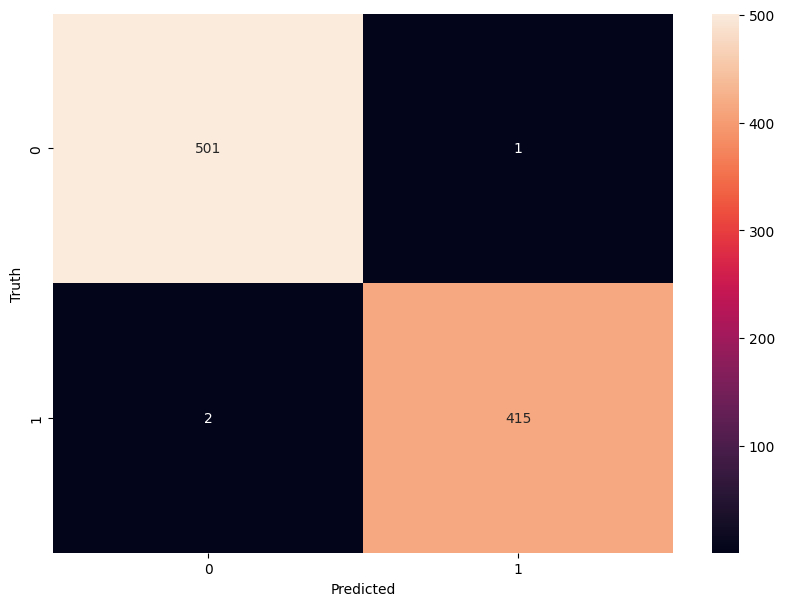

In [37]:
# getting predictions
y_pred = model.predict(images_array)
y_pred = (y_pred >= 0.5).astype(int)
# plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

# Classification Report

In [38]:
# classification report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       502
         1.0       1.00      1.00      1.00       417

    accuracy                           1.00       919
   macro avg       1.00      1.00      1.00       919
weighted avg       1.00      1.00      1.00       919

